In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
import scipy

In [2]:
# set random seed for debugging purpose, need to turn off when perform monte carlo
# np.random.seed(42)

In [3]:
# plots
def gain(w):
    """Return the power as a function of azimuthal angle, phi."""
    phi = np.linspace(0, 2*np.pi, 1000)
    psi = 2*np.pi * 1 / 2 * np.cos(phi)
    j = np.arange(len(w))
    A = np.sum(w[j] * np.exp(j * 1j * psi[:, None]), axis=1)
    g = np.abs(A)**2
    return phi, g

def get_directive_gain(g, minDdBi=-20):
    """Return the "directive gain" of the antenna array producing gain g."""
    DdBi = 10 * np.log10(g / np.max(g))
    return np.clip(DdBi, minDdBi, None)

## channel generation

In [83]:
def rand_angles(M):
    return np.random.randint(0, 180, M)/180*np.pi # 0->180deg

def rand_distances(M):
    return np.random.randint(1000, 2500, M) # 50-250m

def get_path_loss_phase_diff(angles, distances, N, M):
    r = np.arange(N)
    return np.array([lambda_/(4*np.pi*distances[i])*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]) # with path loss
    # return np.array([np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]) # no path loss

def generate_channels_LOS(angles, distances, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    r = np.arange(N)
    h_array_LOS = [lambda_/(4*np.pi*distances[i])*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]
    h_array_LOS_norm_QoS = []
    h_array_LOS_norm_MaxMin = []
    
    for i in range(M):
        # normalization QoS
        h_i_norm_QoS = h_array_LOS[i]/np.sqrt(rho_min_qos_sigma2)
        h_array_LOS_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_array_LOS[i]/sigma_i
        h_array_LOS_norm_MaxMin.append(h_i_norm_MaxMin)
    
    # generate H_i matrix
    H_array_LOS = []
    H_array_LOS_norm_QoS = []
    H_array_LOS_norm_MaxMin = []
    for i in range(M):
        H_array_LOS.append(np.matmul(h_array_LOS[i], np.conjugate(h_array_LOS[i]).T))
        H_array_LOS_norm_QoS.append(np.matmul(h_array_LOS_norm_QoS[i], np.conjugate(h_array_LOS_norm_QoS[i]).T))
        H_array_LOS_norm_MaxMin.append(np.matmul(h_array_LOS_norm_MaxMin[i], np.conjugate(h_array_LOS_norm_MaxMin[i]).T))
        
    return h_array_LOS, h_array_LOS_norm_QoS, h_array_LOS_norm_MaxMin, H_array_LOS, H_array_LOS_norm_QoS, H_array_LOS_norm_MaxMin
        
def generate_channels(N, M, pl=None, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        if pl is not None:
            # path loss model & phase delay for multiple transmit antenna
            h_i = np.sqrt(2)/2*(np.random.randn() + 1j*np.random.randn())*pl[i]
        else:
            h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1))
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin
    

In [44]:
# h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(N, M, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

## Randomization

In [45]:
def recover_w_SVD(W_opt):
    v, d = np.linalg.eig(W_opt)
    w_opt = d[:,0]
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randA(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randB(W_opt):
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    w_opt = np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    
def recover_w_randC(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(W_opt.shape[0], 2)).view(np.complex128)
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    

## Check violation

In [46]:
def check_violation(w, h):
    scale_factor = 1
    constraint = np.abs(np.dot(np.conjugate(h).T, w))[0][0]**2
    # print(constraint)
    violate = constraint < 1
    if violate:
        return np.sqrt(1.0/constraint), constraint
    return scale_factor, constraint

def get_min_scale_factor(w, h_list):
    scale_factor = -np.inf
    for i in range(len(h_list)):
        s, _ = check_violation(w, h_list[i])
        scale_factor = np.max([scale_factor, s])
    return scale_factor

In [198]:
N = 32 # number of transmit antennas
M = 4 # number of mobile users
# P = 1 # transmit power

lambda_ = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

In [217]:
angles = rand_angles(M)
distances = rand_distances(M)

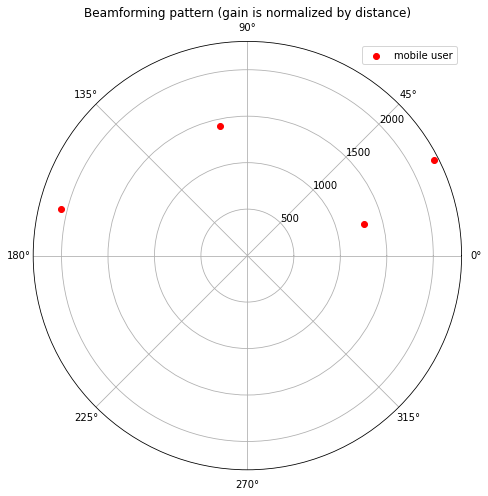

In [218]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized by distance)")
plt.legend()
plt.tight_layout()
plt.show()

## LoS sanity check

In [273]:
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels_LOS(angles, distances, N, M, rho_min_qos_sigma2=1, sigma_i=1)

In [274]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost (dB) = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.linalg.norm(w_min)**2/opt)
    
print("MC 1000 upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.linalg.norm(w_min)**2/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power (dB) boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  393300168.4296168
SVD upper bound power boost (dB) =  5720319803.861842
MC 1000 upper bound power boost (dB) =  1.000007512474236 mean =  1.0000936973759273 std =  4.059232324895947e-05
MC 30*N*M= 3840 upper bound power (dB) boost =  1.000007512474236 mean =  1.0000927408727793 std =  4.026878328072932e-05


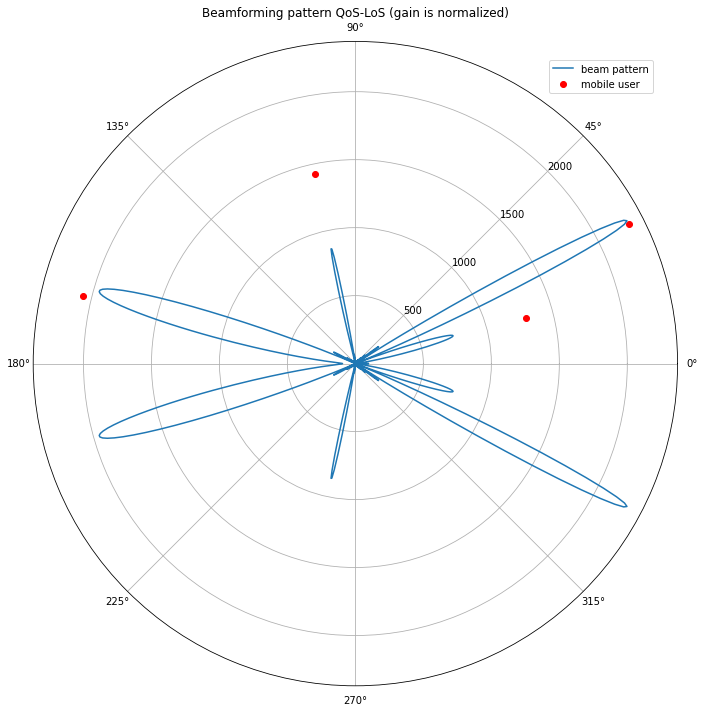

In [275]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS-LoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [237]:
# fig.savefig("fig2_qos_los_4user_32an.png")

## QoS formulation

In [263]:
pl = get_path_loss_phase_diff(angles, distances, N, M)
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(N, M, pl=pl, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

In [264]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost (dB) = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.linalg.norm(w_min)**2/opt)
    
print("MC 1000 upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.linalg.norm(w_min)**2/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power (dB) boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  220860566.1900918
SVD upper bound power boost (dB) =  3611300232.806664
MC 1000 upper bound power boost (dB) =  1.0000006934555619 mean =  1.0000146034809445 std =  8.93270869529224e-06
MC 30*N*M= 3840 upper bound power (dB) boost =  1.0000001538601875 mean =  1.000014486632355 std =  8.740108215932384e-06


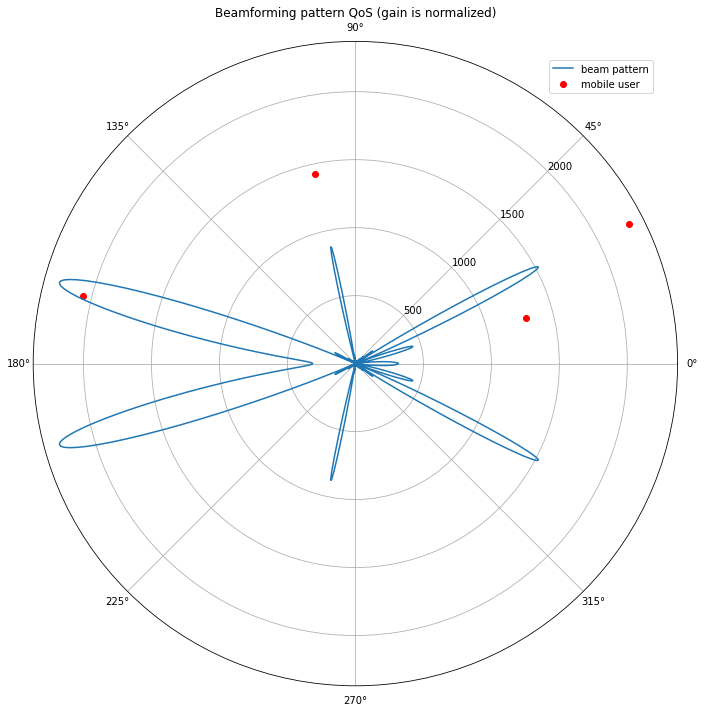

In [265]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [266]:
# fig.savefig("fig3_qos_4user_32an.png")

## MaxMin formulation

In [278]:
W = cp.Variable((N, N), hermitian=True)
t = cp.Variable(1)

constraints = [W >> 0]
constraints += [cp.real(cp.trace(W)) <= 1] # power constraint
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

prob = cp.Problem(cp.Maximize(t),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.log10(np.linalg.norm(w_SVD)**2/opt)
print("SVD upper bound power boost (dB) = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, H_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, H_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, H_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.log10(np.linalg.norm(w_min)**2/opt))
    
print("MC 1000 upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, H_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, H_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, H_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [np.linalg.norm(w_SVD)**2, np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(np.log10(np.linalg.norm(w_min)**2/opt))
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_maxmin = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  9.406488520722317e-10
SVD upper bound power boost (dB) =  28.734419791133003
MC 1000 upper bound power boost (dB) =  27.848053306162726 mean =  28.544334651259213 std =  0.16082436801212213
MC 30*N*M= 3840 upper bound power boost (dB) =  27.83327820188929 mean =  28.54699406327893 std =  0.15888261300035617


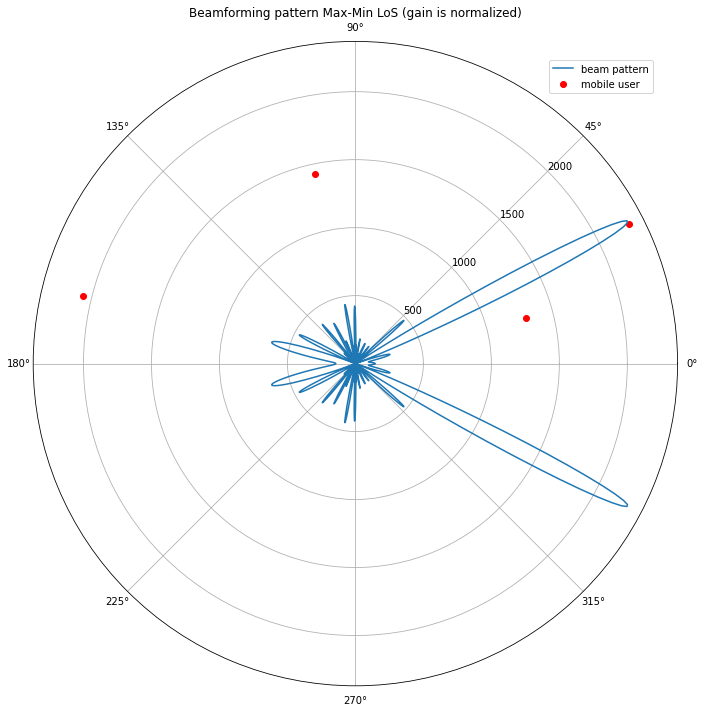

In [279]:
w = w_best_maxmin.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Max-Min LoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [269]:
# fig.savefig("fig4_maxmin_4user_32an.png")

## MaxMin average calc

In [190]:
N = 4 # number of transmit antennas
M = 8 # number of mobile users
# P = 1 # transmit power

lambda_ = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

In [191]:
angles = rand_angles(M)
distances = rand_distances(M)

In [14]:
ubpb_best_list = []
for k in tqdm.tqdm(range(10)):
    pl = get_path_loss_phase_diff(angles, distances, N, M)
    h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(N, M, pl=pl, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)
    
    W = cp.Variable((N, N), hermitian=True)
    t = cp.Variable(1)

    constraints = [W >> 0]
    constraints += [cp.real(cp.trace(W)) <= 1] # power constraint
    constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

    prob = cp.Problem(cp.Maximize(t),
                 constraints)
    opt = prob.solve(solver="MOSEK", verbose=False)
    W_opt = W.value
    
    w_best_tmp = None
    ubpb_best_tmp = np.inf
    for i in range(30*N*M):
        # recover randomization
        w_randA = recover_w_randA(W_opt)
        w_randB = recover_w_randB(W_opt)
        w_randC = recover_w_randC(W_opt)

        scale_factor_randA = get_min_scale_factor(w_randA, H_array_norm_QoS)
        scale_factor_randB = get_min_scale_factor(w_randB, H_array_norm_QoS)
        scale_factor_randC = get_min_scale_factor(w_randC, H_array_norm_QoS)

        w_randA *= scale_factor_randA
        w_randB *= scale_factor_randB
        w_randC *= scale_factor_randC

        w_l = [w_randA, w_randB, w_randC]
        norm_l = [np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

        w_min = w_l[np.argmin(norm_l)]
        ubpb_min = np.log10(np.linalg.norm(w_min)**2/opt)

        if ubpb_min < ubpb_best_tmp:
            w_best_tmp = w_min
            ubpb_best_tmp = ubpb_min
            
    ubpb_best_list.append(ubpb_best_tmp)

100%|████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


In [15]:
np.mean(ubpb_best_list)

3.2014651791802016

In [17]:
t.value[0]

0.18913076890222802

In [ ]:
w_randA